#### plan
1. load trajs
2. load params for trajs
3. unnormalize trajs observations, but not actions
4. compute kl etc

In [1]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import numpy as np 
import os
from scipy.stats import gaussian_kde

import hgail.misc.utils

import utils

In [2]:
def unnormalize(x, mean, std):
    return (x * std) + mean

In [3]:
expert_filepath = '../../data/trajectories/ngsim_1.h5'
expert = utils.load_data(
    expert_filepath, 
    min_length=250, 
    normalize_data=False, 
    clip_std_multiple=10.
)
# normalize actions b/c policies are trained to emulate the normalized values
expert_actions = utils.load_data(
    expert_filepath, 
    min_length=250, 
    normalize_data=True,
    clip_std_multiple=10.,
    act_low=[-4., -.15],
    act_high=[4., .15]
    
)
expert['actions'] = expert_actions['actions']

In [16]:
valdirs = [
    '../../data/experiments/1_gail/imitate/validation/',
    '../../data/experiments/1_infogail/imitate/validation/',
    '../../data/experiments/1_hgail/imitate/validation/',
    '../../data/experiments/1_recurrent_gail/imitate/validation/'
]
params_filepaths = [
    '../../data/experiments/1_gail/imitate/log/itr_3000.npz',
    '../../data/experiments/1_infogail/imitate/log/itr_1000.npz',
    '../../data/experiments/1_hgail/imitate/log/itr_1000.npz',
    '../../data/experiments/1_recurrent_gail/imitate/log/itr_2000.npz'
]
model_labels = [
    'gail',
    'infogail',
    'hgail',
    'recurrent gail'
]
model_trajs = []
ngsim_labels = None
n_models = len(model_labels)
for i in range(n_models):
    trajs, ngsim_labels = utils.load_trajs_labels(valdirs[i])
    params = hgail.misc.utils.load_params(params_filepaths[i])
    for timeperiod in trajs:
        for traj in timeperiod:
            traj['observations'] = unnormalize(
                traj['observations'], 
                params['normalzing']['obs_mean'],
                np.sqrt(params['normalzing']['obs_var']),
            )
    model_trajs.append(trajs)

In [17]:
expert_values = dict()
expert_values['0750am-0805am'] = dict()
expert_bounds = dict()
expert_bounds['0750am-0805am'] = dict()
expert_values['0750am-0805am']['lon_accel'] = gaussian_kde(expert['actions'][:,0])
expert_bounds['0750am-0805am']['lon_accel'] = (np.min(expert['actions'][:,0]), np.max(expert['actions'][:,0]))
expert_values['0750am-0805am']['lat_accel'] = gaussian_kde(expert['actions'][:,1])
expert_bounds['0750am-0805am']['lat_accel'] = (np.min(expert['actions'][:,1]), np.max(expert['actions'][:,1]))
expert_values['0750am-0805am']['velocity'] = gaussian_kde(expert['observations'][:,2])
expert_bounds['0750am-0805am']['velocity'] = (np.min(expert['observations'][:,2]), np.max(expert['observations'][:,2]))
expert_values['0750am-0805am']['jerk'] = gaussian_kde(expert['observations'][:,9])
expert_bounds['0750am-0805am']['jerk'] = (np.min(expert['observations'][:,9]), np.max(expert['observations'][:,9]))
expert_values['0750am-0805am']['ttc'] = gaussian_kde(expert['observations'][:,16])
expert_bounds['0750am-0805am']['ttc'] = (np.min(expert['observations'][:,16]), np.max(expert['observations'][:,16]))

In [18]:
def compute_kl(ref, comp, x):
    logp = ref.logpdf(x)
    p = np.exp(logp)
    logq = comp.logpdf(x)
    return - np.sum(p * (logq - logp))

In [38]:
def compute_emergent_divergence(trajs, labels, bounds, expert, nbins=50):
    # collect values
    emergent = dict()
    for (timeperiod, l) in zip(trajs, labels):
        emergent[l] = dict()
        emergent[l]['lon_accel'] = np.concatenate([traj['actions'][:,0] for traj in timeperiod])
        emergent[l]['lat_accel'] = np.concatenate([traj['actions'][:,1] for traj in timeperiod])
        emergent[l]['velocity'] = np.concatenate([traj['observations'][:,2] for traj in timeperiod])
        emergent[l]['jerk'] = np.concatenate([traj['observations'][:,9] for traj in timeperiod])
        emergent[l]['ttc'] = np.concatenate([traj['observations'][:,16] for traj in timeperiod])
        
    # compute divergences
    divergences = dict()
    for l, l_values in emergent.items():
        
        if l not in expert.keys():
            continue
            
        divergences[l] = dict()
        for k, values in l_values.items():
            x = np.linspace(bounds[l][k][0], bounds[l][k][1], nbins)
            divergences[l][k] = compute_kl(expert[l][k], gaussian_kde(values), x)
            
    return divergences

In [39]:
model_divs = []
for i, trajs in enumerate(model_trajs):
    print('computing divergence for model {}'.format(model_labels[i]))
    divs = compute_emergent_divergence(trajs, ngsim_labels, expert_bounds, expert_values)
    model_divs.append(divs)

computing divergence for model gail
computing divergence for model infogail
computing divergence for model hgail
computing divergence for model recurrent gail


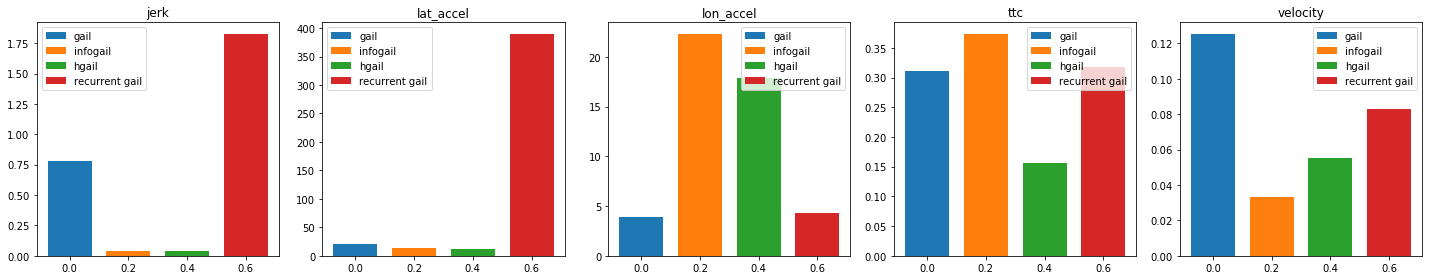

In [40]:
plt.figure(figsize=(20,4))
attr_width = .2
for i, divs in enumerate(model_divs):
    
    for (timeperiod, timeperiod_divs) in divs.items():
        attr_keys = sorted(timeperiod_divs.keys())
        
        for j, attr in enumerate(attr_keys):
            plt.subplot(1,5,j+1)
            plt.title(attr)
            div = timeperiod_divs[attr]
            plt.bar(i*attr_width, div, width=.15, label=model_labels[i])
            if i == len(model_divs) - 1:
                plt.legend()

plt.tight_layout()

<Container object of 50 artists>

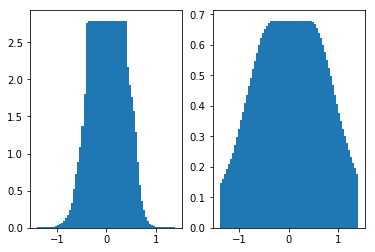

In [41]:
# feat_key = 'observations'
# feat_idx = 2
# feat_name = 'velocity'
feat_key = 'actions'
feat_idx = 0
feat_name = 'lon_accel'
low = expert_bounds['0750am-0805am'][feat_name][0]
high = expert_bounds['0750am-0805am'][feat_name][1]
x = np.linspace(low, high, 50)
ref = expert_values['0750am-0805am'][feat_name]
plt.subplot(1,2,1)
plt.bar(x, ref.pdf(x))
plt.subplot(1,2,2)
vals = np.concatenate([traj[feat_key][:,feat_idx] for traj in model_trajs[2][0]])
comp = gaussian_kde(vals)
plt.bar(x, comp.pdf(x))


In [23]:
print(expert_bounds)

{'0750am-0805am': {'velocity': (3.8103724410853456e-06, 29.570213614914064), 'lon_accel': (-1.0, 1.0), 'ttc': (0.00058768060429761882, 30.0), 'jerk': (-111.2891908640254, 328.24688515367723), 'lat_accel': (-1.0, 1.0)}}
